# EXPLORATORY DATA ANALYSIS

In [2]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn

# Import Library
import numpy as np
import pandas as pd
import pylab
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap

from sklearn.base import TransformerMixin

Import Data

In [3]:
wines = pd.read_csv('winequalityN.csv')

""" Membuat kolom baru 'quality_label' berdasarkan nilai kolom 'quality':
    - 'low' jika nilai quality <= 5
    - 'medium' jika nilai quality <= 7
    - 'high' jika nilai quality > 7 """

wines['quality_label'] = wines.quality.apply(lambda q: 'low' if q <= 5 else 'medium' if q <= 7 else 'high')

# Mengacak urutan data untuk memastikan distribusi acak, menggunakan random_state=101 untuk hasil yang konsisten
wines = wines.sample(frac=1, random_state=101).reset_index(drop=True)

In [4]:
import pandas as pd
import numpy as np

def rstr(df, pred=None):
    # Hitung statistik dasar
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    distincts = df.apply(lambda x: x.nunique())
    nulls = df.apply(lambda x: x.isnull().sum())
    missing_ration = (df.isnull().sum() / obs) * 100
    skewness = df.skew(numeric_only=True)
    kurtosis = df.kurt(numeric_only=True)

    # Ambil nilai unik sebagai string
    uniques = df.apply(lambda x: str(x.unique()[:5]) + '...' if len(x.unique()) > 5 else str(x.unique()))

    print('Data shape:', df.shape)

    # Jika pred tidak ditentukan, gabungkan semua metrik tanpa korelasi
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis']
        str_df = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis=1)
    # Jika pred ditentukan, tambahkan korelasi dengan kolom pred
    else:
        corr = df.corr(numeric_only=True)[pred]
        str_df = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis=1)
        corr_col = 'corr ' + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis', corr_col]

    # Memeriksa apakah jumlah kolom sesuai sebelum menetapkan nama kolom
    print(f"Concatenated DataFrame shape: {str_df.shape}")
    if str_df.shape[1] != len(cols):
        raise ValueError(f"Column mismatch: DataFrame has {str_df.shape[1]} columns, but {len(cols)} column names provided")

    str_df.columns = cols
    print('___________________________\nData types:\n', str_df.types.value_counts())
    print('___________________________')
    return str_df

# Load and preprocess data
wines = pd.read_csv('winequalityN.csv')
wines['quality_label'] = wines.quality.apply(lambda q: 'low' if q <= 5 else 'medium' if q <= 7 else 'high')
wines = wines.sample(frac=1, random_state=101).reset_index(drop=True)

# Buat ringkasan dengan korelasi ke 'quality'
details = rstr(wines, 'quality')

# Tampilkan, urut berdasarkan missing_ration
print(details.sort_values(by='missing_ration', ascending=False))

Data shape: (6497, 14)
Concatenated DataFrame shape: (14, 9)
___________________________
Data types:
 types
float64    11
object      2
int64       1
Name: count, dtype: int64
___________________________
                        types  counts  distincts  nulls  missing_ration  \
fixed acidity         float64    6487        106     10        0.153917   
pH                    float64    6488        108      9        0.138525   
volatile acidity      float64    6489        187      8        0.123134   
sulphates             float64    6493        111      4        0.061567   
citric acid           float64    6494         89      3        0.046175   
residual sugar        float64    6495        316      2        0.030783   
chlorides             float64    6495        214      2        0.030783   
type                   object    6497          2      0        0.000000   
total sulfur dioxide  float64    6497        276      0        0.000000   
free sulfur dioxide   float64    6497        1

In [5]:
wines.quality_label.value_counts()

quality_label
medium    3915
low       2384
high       198
Name: count, dtype: int64

In [6]:
wines.dropna().quality_label.value_counts()

quality_label
medium    3894
low       2372
high       197
Name: count, dtype: int64

In [7]:
# Menghapus baris dengan nilai null dari DataFrame wines
wines.dropna(inplace=True)

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """
        Mengisi nilai yang hilang:
        - Kolom bertipe object diisi dengan nilai paling sering muncul.
        - Kolom bertipe lain diisi dengan rata-rata kolom.
        """
    def fit(self, X, y=None):

        # Menentukan nilai pengisi untuk setiap kolom
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        # Mengisi nilai yang hilang dengan nilai dari self.fill
        return X.fillna(self.fill)

# Menerapkan imputasi pada DataFrame wines
wines = DataFrameImputer().fit_transform(wines)

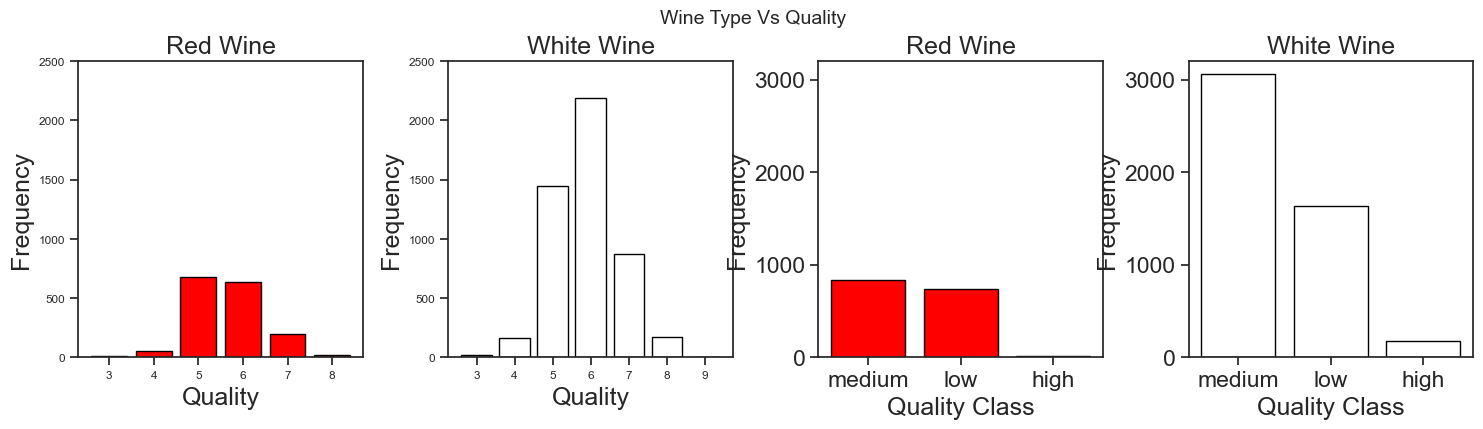

In [8]:
fig = plt.figure(figsize = (18, 4))
title = fig.suptitle("Wine Type Vs Quality", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

# Subplot 1: Bar plot untuk kualitas anggur merah
ax1 = fig.add_subplot(1,4, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Quality")
ax1.set_ylabel("Frequency")
rw_q = wines.quality[wines.type == 'red'].value_counts()
rw_q = (list(rw_q.index), list(rw_q.values))
ax1.set_ylim([0, 2500])
ax1.tick_params(axis='both', which='major', labelsize=8.5)
bar1 = ax1.bar(rw_q[0], rw_q[1], color='red', edgecolor='black', linewidth=1)

# Subplot 2: Bar plot untuk kualitas anggur putih
ax2 = fig.add_subplot(1,4, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("Quality")
ax2.set_ylabel("Frequency")
ww_q = wines.quality[wines.type == 'white'].value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax2.set_ylim([0, 2500])
ax2.tick_params(axis='both', which='major', labelsize=8.5)
bar2 = ax2.bar(ww_q[0], ww_q[1], color='white', edgecolor='black', linewidth=1)

# Subplot 3: Bar plot untuk label kualitas anggur merah
ax3 = fig.add_subplot(1,4, 3)
ax3.set_title("Red Wine")
ax3.set_xlabel("Quality Class")
ax3.set_ylabel("Frequency")
rw_q = wines.quality_label[wines.type == 'red'].value_counts()
rw_q = (list(rw_q.index), list(rw_q.values))
ax3.set_ylim([0, 3200])
bar3 = ax3.bar(list(range(len(rw_q[0]))), rw_q[1], color='red', edgecolor='black', linewidth=1, tick_label =rw_q[0])

# Subplot 4: Bar plot untuk label kualitas anggur putih
ax4 = fig.add_subplot(1,4, 4)
ax4.set_title("White Wine")
ax4.set_xlabel("Quality Class")
ax4.set_ylabel("Frequency")
ww_q = wines.quality_label[wines.type == 'white'].value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax4.set_ylim([0, 3200])
bar4 = ax4.bar(list(range(len(ww_q[0]))), ww_q[1], color='white', edgecolor='black', linewidth=1, tick_label =ww_q[0])

In [9]:
subset_attributes = wines.columns

# Menghitung statistik deskriptif untuk anggur merah dan anggur putih, dibulatkan ke 2 desimal
rs = round(wines.loc[wines.type == 'red', subset_attributes].describe(),2)
ws = round(wines.loc[wines.type == 'white', subset_attributes].describe(),2)

# Menggabungkan statistik anggur merah dan putih secara vertikal dengan label
pd.concat([rs, ws], axis=0, keys=['Red Wine Statistics', 'White Wine Statistics']).T

Red Wine Statistics                                    \
                                   count   mean    std   min    25%    50%   
fixed acidity                     1593.0   8.33   1.74  4.60   7.10   7.90   
volatile acidity                  1593.0   0.53   0.18  0.12   0.39   0.52   
citric acid                       1593.0   0.27   0.19  0.00   0.09   0.26   
residual sugar                    1593.0   2.54   1.41  0.90   1.90   2.20   
chlorides                         1593.0   0.09   0.05  0.01   0.07   0.08   
free sulfur dioxide               1593.0  15.84  10.44  1.00   7.00  14.00   
total sulfur dioxide              1593.0  46.46  32.91  6.00  22.00  38.00   
density                           1593.0   1.00   0.00  0.99   1.00   1.00   
pH                                1593.0   3.31   0.15  2.74   3.21   3.31   
sulphates                         1593.0   0.66   0.17  0.33   0.55   0.62   
alcohol                           1593.0  10.42   1.07  8.40   9.50  10.20   
quality                           1593.0   5.64   0.81  3.00   5.00   6.00   

                                    White Wine Statistics                 \
                        75%     max                 count    mean    std   
fixed acidity          9.20   15.90                4870.0    6.86   0.84   
volatile acidity       0.64    1.58                4870.0    0.28   0.10   
citric acid            0.42    1.00                4870.0    0.33   0.12   
residual sugar         2.60   15.50                4870.0    6.39   5.07   
chlorides              0.09    0.61                4870.0    0.05   0.02   
free sulfur dioxide   21.00   72.00                4870.0   35.32  17.01   
total sulfur dioxide  62.00  289.00                4870.0  138.34  42.49   
density                1.00    1.00                4870.0    0.99   0.00   
pH                     3.40    4.01                4870.0    3.19   0.15   
sulphates              0.73    2.00                4870.0    0.49   0.11   
alcohol               11.10   14.90                4870.0   10.52   1.23   
quality                6.00    8.00                4870.0    5.88   0.89   

                                                            
                       min     25%     50%     75%     max  
fixed acidity         3.80    6.30    6.80    7.30   14.20  
volatile acidity      0.08    0.21    0.26    0.32    1.10  
citric acid           0.00    0.27    0.32    0.39    1.66  
residual sugar        0.60    1.70    5.20    9.90   65.80  
chlorides             0.01    0.04    0.04    0.05    0.35  
free sulfur dioxide   2.00   23.00   34.00   46.00  289.00  
total sulfur dioxide  9.00  108.00  134.00  167.00  440.00  
density               0.99    0.99    0.99    1.00    1.04  
pH                    2.72    3.09    3.18    3.28    3.82  
sulphates             0.22    0.41    0.47    0.55    1.08  
alcohol               8.00    9.50   10.40   11.40   14.20  
quality               3.00    5.00    6.00    6.00    9.00

# DATA PREPROCESSING & TRANSFORMATION

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [11]:
# Pisahkan fitur dan target
X = wines.drop(['quality', 'quality_label'], axis=1)  # Drop kolom quality dan quality_label
y = wines['quality']

# Identifikasi kolom numerik dan kategorikal
numeric_cols = X.select_dtypes(include=['float64']).columns
categorical_cols = ['type']

# Kolom dengan skewness tinggi untuk transformasi
high_skew_cols = ['chlorides', 'sulphates', 'residual sugar']

# Fungsi untuk clipping outliers berdasarkan IQR
def clip_outliers(df, columns):
    df_clipped = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clipped[col] = df_clipped[col].clip(lower_bound, upper_bound)
    return df_clipped

# Terapkan clipping outliers
X = clip_outliers(X, numeric_cols)

# Pipeline untuk preprocessing numerik
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Imputasi dengan median
    ('power_transform', PowerTransformer(method='yeo-johnson')),  # Transformasi untuk skewness
    ('scaler', StandardScaler())  # Normalisasi
])

# Pipeline untuk preprocessing kategorikal
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))  # One-hot encoding
])

# Gabungkan transformer untuk numerik dan kategorikal
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Pipeline lengkap dengan feature selection
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k=8))  # Pilih 8 fitur terbaik
])

# Terapkan pipeline ke data
X_preprocessed = pipeline.fit_transform(X, y)

# Dapatkan nama fitur setelah preprocessing
# 1. Untuk kolom numerik
numeric_features = numeric_cols.tolist()
# 2. Untuk kolom kategorikal setelah one-hot encoding
cat_features = pipeline.named_steps['preprocessor'].transformers_[1][1]\
    .named_steps['onehot'].get_feature_names_out(categorical_cols).tolist()
# Gabungkan semua nama fitur
selected_features_mask = pipeline.named_steps['feature_selection'].get_support()
all_features = numeric_features + cat_features
selected_features = [all_features[i] for i in range(len(all_features)) if selected_features_mask[i]]

# Konversi hasil preprocessing ke DataFrame
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=selected_features)


In [12]:
# Tampilkan hasil
print("Dimensi data setelah preprocessing:", X_preprocessed_df.shape)
print("\nFitur yang dipilih setelah preprocessing:")
print(selected_features)
print("\n5 baris pertama dari data yang telah dipreproses:")
print(X_preprocessed_df.head())

Dimensi data setelah preprocessing: (6463, 8)

Fitur yang dipilih setelah preprocessing:
['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'free sulfur dioxide', 'density', 'alcohol', 'type_white']

5 baris pertama dari data yang telah dipreproses:
   fixed acidity  volatile acidity  citric acid  chlorides  \
0       0.265153         -0.195513     0.787382  -0.567804   
1      -0.123194          1.766942    -1.946184   0.595154   
2       1.910952          1.023367    -0.579015   1.600224   
3       1.025307          0.061272     0.635595   0.458926   
4       0.787548         -0.195513     0.711490   0.458926   

   free sulfur dioxide   density   alcohol  type_white  
0             1.081980  1.605549 -1.442013         1.0  
1            -1.125267  0.033508  0.855293         0.0  
2            -0.955265  1.125152 -0.298148         0.0  
3            -1.734758  0.223904  0.714904         0.0  
4             0.180254  0.646463 -0.607242         1.0  


In [13]:
# Simpan data yang telah dipreproses ke file csv baru
X_preprocessed_df.to_csv('wine_preprocessed.csv', index=False)
y.to_csv('wine_target.csv', index=False)

In [15]:
# Python Notebook - Cell 1: Import Necessary Libraries

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # Import layers explicitly
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

# Optional: Ignore warnings for cleaner output
warnings.filterwarnings('ignore') 

print(f"TensorFlow Version: {tf.__version__}")
print("Libraries imported successfully.")

TensorFlow Version: 2.19.0
Libraries imported successfully.


In [17]:
# Python Notebook - Cell 2: Check for GPU

print("--- Checking for GPU ---")
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"GPU Available: True")
        print(f"Number of Physical GPUs Available: {len(gpus)}")
        print(f"Number of Logical GPUs Available: {len(logical_gpus)}")
        # Often Physical GPUs == Logical GPUs unless you configure otherwise
        # Print the name of the first GPU
        print(f"Using GPU: {tf.test.gpu_device_name()}") 
        # TensorFlow automatically prefers GPU if available
        device = '/GPU:0'
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print("GPU Configuration Error:", e)
        print("GPU Available: False (Runtime Error during setup)")
        device = '/CPU:0'
else:
    print("GPU Available: False")
    print("Using CPU")
    device = '/CPU:0'

print(f"TensorFlow will attempt to use device: {device}")

--- Checking for GPU ---
GPU Available: False
Using CPU
TensorFlow will attempt to use device: /CPU:0
